[23 经典卷积神经网络 LeNet](https://www.bilibili.com/video/BV1t44y1r7ct?spm_id_from=333.999.0.0)

### 手写数字识别
<img src="picture\屏幕截图 2022-05-10 235025.png"></a>


In [82]:
import torch
from torch import nn
from d2l import torch as d2l

In [83]:
# torch.view的用法
# view（）用于改变tensor的形状
# 这里的-1表示让view自己去决定这一维度应该选取多大
x = torch.ones(2,3,2)
xv = x.view(-1,3)
x,xv

(tensor([[[1., 1.],
          [1., 1.],
          [1., 1.]],
 
         [[1., 1.],
          [1., 1.],
          [1., 1.]]]),
 tensor([[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]))

In [84]:
class Reshape(torch.nn.Module):
    def forward(self, x):
        return x.view(-1, 1, 28, 28)

In [85]:
net = torch.nn.Sequential(
    Reshape(),
    # 原始图片为32*32 reshape为28*28后 需要进行2的填充
    # 这里填充的目的是为了防止边缘信息被剪掉
    nn.Conv2d(1,6,kernel_size=5,padding=2),
    # 激活函数
    nn.Sigmoid(),
    # 卷积核为2 步幅为2 的均值池化层
    nn.AvgPool2d(kernel_size=2,stride=2),

    nn.Conv2d(6,16,kernel_size=5),
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),

    # 展平层，然后开始全连接层
    nn.Flatten(),

    nn.Linear(16*5*5,120),
    nn.Sigmoid(),

    nn.Linear(120,84),
    nn.Sigmoid(),
    nn.Linear(84,10)
    # 我们对原始模型做了⼀点小改动，去掉了最后⼀层的⾼斯激活
)

- 请注意，在整个卷积块中，与上⼀层相⽐，每⼀层特征的⾼度和宽度都减小了。
- 第⼀个卷积层使⽤2 个像素的填充，来补偿5X5 卷积核导致的特征减少。
- 相反，第⼆个卷积层没有填充，因此⾼度和宽度都减少了4 个像素。随着层叠的上升，通道的数量从输⼊时的1 个，增加到第⼀个卷积层之后的6 个，再到第⼆个卷积层
之后的16 个。
- 同时，每个汇聚层的⾼度和宽度都减半。最后，每个全连接层减少维数，最终输出⼀个维数与结果分类数相匹配的输出。

In [86]:
# 这里可以预先检查一下，输入输出是否合理
X = torch.rand(size=(1,1,28,28),dtype=torch.float32)
for layer in net:
    X = layer(X)
    # \t相当于tab按键
    print(layer.__class__.__name__,'output shape: \t',X.shape)
# 尝试用X进行试验，可以看出每层输出的维度，这样也可以使得输入输出按照自己需求来

Reshape output shape: 	 torch.Size([1, 1, 28, 28])
Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
Sigmoid output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
Sigmoid output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


In [87]:
# 数据加载
batch_size = 256
train_iter,test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [88]:
iter(train_iter).__next__()[0].shape

torch.Size([256, 1, 28, 28])

In [89]:
# 对评估函数进行GPU的实现
def evaluate_accuracy_gpu(net,data_iter,device = None):
    """使用GPU进行计算"""
    # isinstance函数 用于判别
    # 用于选择第一个设备
    if isinstance(net,torch.nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2)
    for X,y in data_iter:
        # 如果x是list，那么把设备都加进去
        if isinstance(X,list):
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        # 返回准确率、y的元素个数
        metric.add(d2l.accuracy(net(X),y),y.numel())
    return metric[0]/metric[1]


```
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
img = img.to(device)
```
-  这段代码的意思就是将所有最开始读取数据时的tensor变量copy一份到device所指定的GPU上去，之后的运算都在GPU上进行。

In [90]:
def train_ch6(net,train_iter,test_iter,num_epochs,lr,device):
    """Gpu 训练模型"""
    # 权重初始化函数
    def init_weights(m):
        if isinstance(m,nn.Linear) or isinstance(m,nn.ConstantPad2d):
            nn.init.xavier_uniform_(m.weight)
    # 应用权重分配
    net.apply(init_weights)
    print("traing on",device)
    # 模型构建好后整体进行迁移
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(),lr = lr)
    loss = nn.CrossEntropyLoss()
    # 该函数主要用于展示
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
    legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    # epoch指的是整体数据需要循环十遍
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，范例数
        metric = d2l.Accumulator(3)
        net.train()
        # 标准循环
        for i, (X, y) in enumerate(train_iter):
            # 以batch_size大小进行训练
            timer.start()
            # 梯度归零
            optimizer.zero_grad()
            # 输入输出放入GPU
            X, y = X.to(device), y.to(device)
            # 正向操作
            y_hat = net(X)
            # 计算损失
            l = loss(y_hat, y)
            # 计算梯度
            l.backward()
            # 迭代
            optimizer.step()
            # 以下部分主要用于输出一些指标
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                (train_l, train_acc, None))
        
        test_acc = evaluate_accuracy_gpu(net,test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, 'f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec 'f'on {str(device)}')



loss 0.486, train acc 0.817, test acc 0.797
80326.6 examples/sec on cuda:0


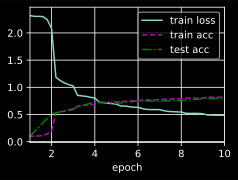

In [91]:
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

### Q/A
- Q: 池化和卷积是否适合时序类数据 
    - A: 应用较少，但可以尝试
    
- Q: 第二个卷积层通道数增加到了16，这意味着信息被放大了吗？
    - A: 老中医建议：如果卷积后图像如果减半的话，可以把通道数翻倍，通道数增加意味着同一个像素能表示的信息增加了

- Q: 为什么用view而不是reshape？
    - A: 大部分情况下没有区别，view一般不会改变原有数据形状。
    - reshape会改变内容储存位置，view不会改变，有些情况下可能会报错

- Q: 为什么要多个核去卷积，多通道增加了什么信息
    - 第19节可以看出，不同的卷积核能够起到不同的作用，如能够实现锐化、边缘检测、高斯模糊等模式，这里多通道意味着让神经网络自己去选择合适的模式来匹配。

- 


